### Howto


1. Decide if wanting to process the data and evaluate the same as CRT-Net paper, ie allow whatever label classes are in the data, but for each sample, just pick the first diagnosis OR do it PhysioNet competition style where only samples from a certain number of labels (as per csv file) are used but also each sample can have multiple labels
1. If you want CRT-Net style, run the cell where data is loaded with load_data given the argument adjust_classes_for_physionet as false. This will produce three file, the data samples themselves, the one hot encoded labels (only one per sample) and the discovered class names, to make it easier later to translate on hot labels to readable class names
1. If you want PhysioNet style, run cell with load_data given the argument adjust_classes_for_physionet as true
1. Run the cell that creates the train/evaluate functions plus creates the baseline crt_net model
1. Run other cells to create other models
1. Change the cell to read whatever numpy datafiles you like, and train/evaluate. It will work out whether to do multilabel or single label based on the onehot encoding


The below reads .hea and .mat file pairs and then :

- Standardises the sample lengths to the most common length (unless overridden), and sampling frequency to the most common frequency.
- One hot encodes the diagnostic class label, either picking the first "primary" label, or encoding all labels. The first case is consistency with the CRT-Net paper, the second for consistency with PhysioNet challenge
- To also be consistent with the PhysioNet challenge, it is also catered to restrict the classes to a certain specified set (via csv file), and also to ensure the "normal" class is always present



In [11]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import wfdb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix


snomed_to_abbreviation = {
    '7':'164884008',
    '2':'164889003',
    '4':'164909002',
    '9':'164931005',
    '3':'270492004',
    '6':'284470004',
    '1':'426783006',
    '8':'429622005',
    '5':'59118001'
}

def read_records(record_files, csv_file_path=None):
    records = []
    labels = []

    if (csv_file_path is not None):
        df = pd.read_csv(csv_file_path)

    for record_file in record_files:
        record = wfdb.rdrecord(record_file)

        if(csv_file_path is not None):
            recording_id = record.file_name[0].split('.')[0]  # Assuming the recording ID is in the file name
        
            # Extract the First_label for the corresponding recording (numbner) and map it longer number
            first_label_str = df[df['Recording'] == recording_id]['First_label'].astype(str).values[0]
            first_label_mapped = snomed_to_abbreviation[first_label_str]
            
            labels.append(first_label_mapped)

        for comment in record.comments:
            if comment.startswith('Dx') or comment.startswith(' Dx'):
                dxs = set(arr.strip() for arr in comment.split(': ')[1].split(','))
                labels.append(dxs)
                    
        records.append(wfdb.rdrecord(record_file))
    return records, labels


def create_one_hot_labels(all_labels, target_classes, num_recordings, single_label):
    discard_index = list()
    labels = np.zeros((num_recordings, len(target_classes)))  # , dtype=np.bool)
    for i in range(num_recordings):
        dxs = all_labels[i]
        flag = np.zeros((1, len(dxs)), dtype=bool)
        count = 0
        for dx in dxs:
            if dx in target_classes:
                j = target_classes.index(dx)
                labels[i, j] = 1
                flag[0, count] = True
                
                # Break out of the loop if adjust_classes_for_physionet is not set
                if single_label:
                    break

            count += 1

        # note any recordings that don't have any of the classes we are looking for
        if np.any(flag) == False:
            discard_index.append(i)

    return labels, discard_index

def get_unique_classes(all_labels, valid_classes=None):

    classes2 = list()
    for i in range(len(all_labels)):
        dxs = all_labels[i]
        for dx in dxs:
            if valid_classes is None or dx in valid_classes:
                classes2.append(dx)

    classes3 = list()
    for x in classes2:
        if x not in classes3:
            classes3.append(x)

    classes3 = sorted (classes3)
    return classes3

def find_records(directory):
    record_files = []
    for dirpath, _, filenames in os.walk(directory):
        for f in sorted(filenames):
            file_path = os.path.join(dirpath, f)
            if os.path.isfile(file_path) and not f.lower().startswith('.'):
                file, ext = os.path.splitext(file_path)
                if ext.lower() == '.hea':
                    record_files.append(file)
    if record_files:
        return record_files
    else:
        raise IOError('No record files found.')

def filter(data, labels, index):
    labels = [labels[i] for i in range(len(labels)) if i not in index]
    data = [data[i] for i in range(len(data)) if i not in index]
    return labels, data

def consolidate_equivalent_classes(one_hot_encoded_labels, unique_classes):
    equivalent_classes_collection = [['713427006', '59118001'], ['284470004', '63593006'], ['427172004', '17338001']]

    # For each set of equivalent class, use only one class as the representative class for the set and discard the other classes in the set.
    # The label for the representative class is positive if any of the labels in the set is positive.
    remove_classes = list()
    remove_indices = list()
    for equivalent_classes in equivalent_classes_collection:
        equivalent_classes = [x for x in equivalent_classes if x in unique_classes]
        if len(equivalent_classes)>1:
            other_classes = equivalent_classes[1:]
            equivalent_indices = [unique_classes.index(x) for x in equivalent_classes]
            representative_index = equivalent_indices[0]
            other_indices = equivalent_indices[1:]

            one_hot_encoded_labels[:, representative_index] = np.any(one_hot_encoded_labels[:, equivalent_indices], axis=1)
            remove_classes += other_classes
            remove_indices += other_indices

    for x in remove_classes:
        unique_classes.remove(x)
    one_hot_encoded_labels = np.delete(one_hot_encoded_labels, remove_indices, axis=1)

    return one_hot_encoded_labels, unique_classes

def set_labels_to_normal_if_none_other(labels, unique_classes, normal_class):
    # If the labels are negative for all classes, then change the label for the normal class to positive.
    normal_index = unique_classes.index(normal_class)
    for i in range(len(labels)):
        num_positive_classes = np.sum(labels[i, :])
        if num_positive_classes==0:
            labels[i, normal_index] = 1

    return labels

def ensure_normal_class(unique_classes, normal_class):
    if normal_class not in unique_classes:
        unique_classes.add(normal_class)
        print('- The normal class {} is not one of the label classes, so it has been automatically added, but please check that you chose the correct normal class.'.format(normal_class))
    unique_classes = sorted(unique_classes)
    return unique_classes

def read_scored_classes():
    scored = list()
    with open('dx_mapping_scored.csv', 'r') as f:
        for l in f:
            dxs = (l.split(','))
            scored.append(dxs[1])
    return (sorted(scored[1:]))

def filter_out(one_hot_encoded_labels, records, discard_index):
    one_hot_encoded_labels = [one_hot_encoded_labels[i] for i in range(len(one_hot_encoded_labels)) if i not in discard_index]
    records = [records[i] for i in range(len(records)) if i not in discard_index]

    return one_hot_encoded_labels, records

def load_records(record_file_list, adjust_classes_for_physionet, single_label, csv_file, normal_class):
        
    if len(record_file_list) == 0:
        raise ValueError('No record files found.')

    num_recordings = len(record_file_list)

    records, all_labels = read_records(record_file_list, csv_file)

    scored = None
    if adjust_classes_for_physionet:
        scored = read_scored_classes()

    unique_classes = get_unique_classes(all_labels, scored)

    if (normal_class is not None):
        unique_classes = ensure_normal_class(unique_classes, normal_class)
    
    one_hot_encoded_labels, discard_index = create_one_hot_labels(all_labels, unique_classes, num_recordings, single_label=single_label)

    if (adjust_classes_for_physionet):
        one_hot_encoded_labels, unique_classes = consolidate_equivalent_classes(one_hot_encoded_labels, unique_classes)
    
    if (normal_class is not None):
        one_hot_encoded_labels = set_labels_to_normal_if_none_other(one_hot_encoded_labels, unique_classes, normal_class)
    
    one_hot_encoded_labels, records = filter_out(one_hot_encoded_labels, records, discard_index)

    return one_hot_encoded_labels, records, unique_classes

def standardise_length(data, target_length):
    number_of_leads = data.shape[0]
    
    if len(data[0])<=target_length:
        ext= np.zeros([number_of_leads,target_length])
        for i in range(0,number_of_leads):
            ext[i][0:len(data[i])]=data[i]
        return ext.T  
    else:
        cut = np.zeros([number_of_leads,target_length])
        for i in range(number_of_leads):
            tocut = len(data[0])- target_length
            cut[i] = data[i][tocut:]
        return cut.T 

def resample(data, src_frq, trg_frq):

    if src_frq == trg_frq:
        return data

    N_src = data.shape[0]
    N_trg = int(N_src * trg_frq / src_frq)
    
    resampled = np.zeros((N_trg, data.shape[1]), dtype='float32')
    for i in range(data.shape[1]):
        resampled[:,i] = np.interp(np.linspace(0, N_src, N_trg), np.arange(N_src), data[:, i])
        
    return resampled

def standardise_data_samples(records, fixed_sample_length=None):
    standardised_data = list()

    # find the most common fs
    fss = [record.fs for record in records]

    target_fs = max(set(fss), key=fss.count)

    # find the most common sig_len
    sig_lens = [record.sig_len for record in records]

    if (fixed_sample_length is not None):
        target_length = fixed_sample_length
    else:
        target_length = max(set(sig_lens), key=sig_lens.count)

    for i in range(len(records)):
        datum = records[i].p_signal.T
        datum = resample(datum,records[i].fs, target_fs)
        datum = standardise_length(datum, target_length)
        standardised_data.append(datum)

    return standardised_data

def load_data(input_directory, adjust_classes_for_physionet=False, single_label=False, csv_file=None, normal_class=None, fixed_sample_length=None):
    record_file_list = find_records(input_directory)
    
    one_hot_encoded_labels, records, classes = load_records(record_file_list, adjust_classes_for_physionet, single_label=single_label, csv_file=csv_file, normal_class=normal_class)
    samples = standardise_data_samples(records, fixed_sample_length=fixed_sample_length)
            
    one_hot_encoded_labels = np.stack(one_hot_encoded_labels, axis =0)
    samples = np.stack(samples, axis =0)

    return one_hot_encoded_labels, samples, classes



Run below to get an numpy output of samples, single one hot encoded label and the class names for the China 2018 data as used by the CRT-Net paper.

In [12]:
output_directory = 'data'
input_directory = 'cpsc_2018'
    
one_hot_encoding_labels, samples, classes = load_data(input_directory, adjust_classes_for_physionet=False, single_label=True, csv_file='REFERENCE.csv', fixed_sample_length=3000)

# maps SNOMED CT codes to classes
snomed_to_abbreviation = {
    '164884008': 'PVC',
    '164889003': 'AF',
    '164909002': 'LBBB',
    '164931005': 'STE',
    '270492004': 'IAVB',
    '284470004': 'PAC',
    '426783006': 'N',
    '429622005': 'STD',
    '59118001': 'RBBB'
}

# map classes to abbreviations
mapped_abbreviations = [snomed_to_abbreviation.get(code, None) for code in classes]

# save the data to a file
np.save(os.path.join(output_directory, 'cpsc_2018_crtnet_singlelabel_samples.npy'), samples)
np.save(os.path.join(output_directory, 'cpsc_2018_crtnet_singlelabel_one_hot_encoding_labels.npy'), one_hot_encoding_labels)
np.save(os.path.join(output_directory, 'cpsc_2018_crtnet_singlelabel_classes.npy'), mapped_abbreviations)


In [10]:
output_directory = 'data'
input_directory = 'cpsc_2018'
    
one_hot_encoding_labels, samples, classes = load_data(input_directory, adjust_classes_for_physionet=False, single_label=False)

# maps SNOMED CT codes to classes
snomed_to_abbreviation = {
    '164884008': 'PVC',
    '164889003': 'AF',
    '164909002': 'LBBB',
    '164931005': 'STE',
    '270492004': 'IAVB',
    '284470004': 'PAC',
    '426783006': 'N',
    '429622005': 'STD',
    '59118001': 'RBBB'
}

# map classes to abbreviations
mapped_abbreviations = [snomed_to_abbreviation.get(code, None) for code in classes]

# save the data to a file
np.save(os.path.join(output_directory, 'cpsc_2018_crtnet_multilabel_samples.npy'), samples)
np.save(os.path.join(output_directory, 'cpsc_2018_crtnet_multilabel_one_hot_encoding_labels.npy'), one_hot_encoding_labels)
np.save(os.path.join(output_directory, 'cpsc_2018_crtnet_multilabel_classes.npy'), mapped_abbreviations)


Run below to get an numpy output of samples, multilabel one hot encoded labels and the class names for any PhysioNet data. This data will be restricted to the PhysioNet challenge list of classes and will be guaranteed to include the "normal" class.

The can be run on any set of sets of PhysioNet data, including China 2018, PTB-XL etc

In [ ]:
output_directory = 'data'
input_directory = 'cpsc_2018'
    
one_hot_encoding_labels, samples, classes = load_data(input_directory, adjust_classes_for_physionet=True, single_label=False, normal_class='426783006')
# save the data to a file
np.save(os.path.join(output_directory, 'cpsc_2018_physionet_samples.npy'), samples)
np.save(os.path.join(output_directory, 'cpsc_2018_physionet_one_hot_encoding_labels.npy'), one_hot_encoding_labels)
np.save(os.path.join(output_directory, 'cpsc_2018_physionet_classes.npy'), classes)


Create functions to 
a) Train and evaluate a model, be it multilabel or single label
b) Create our best attempt at the matching architecture, regularisation and hyperparameters for CRT-Net

In [15]:
from tensorflow.keras import layers
import keras_nlp as nlp 
import tensorflow.keras as keras
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from numpy import argmax
import pandas as pd
import tensorflow as tf
from importlib import reload
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from src import crtnet_models
from sklearn.metrics import accuracy_score

reload(crtnet_models)


def train_and_evaluate_model(model, samples, one_hot_encoding_labels, classes, multilabel, callbacks=None, epochs=10, batch_size=64, style=None):
    
    train_x, validation_x, train_y, validation_y = train_test_split(samples, one_hot_encoding_labels, test_size=0.1, random_state=42)
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(validation_x, validation_y), callbacks=callbacks)

    pd.DataFrame(history.history).plot(
        figsize=(8, 5), xlim=[0, epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
        style=["r--", "r--.", "b-", "b-*"] if style is None else style)
    plt.legend(loc="lower left")
    plt.show()
        
    # Classification Report
    if classes is None:
        classes = ["Class " + str(i) for i in range(len(np.unique(validation_y)))]

    y_pred = model.predict(validation_x)

    if (multilabel):
        # Binarize y_pred to one-hot encoding if it contains probabilities
        y_pred = (y_pred > 0.5).astype(int)

        # Calculate overall accuracy
        overall_accuracy = accuracy_score(validation_y, y_pred)
        print(f"Overall Accuracy: {overall_accuracy:.2%}")

        # Generate classification report
        report = classification_report(y_true=validation_y, y_pred=y_pred, labels=list(range(validation_y.shape[1])), target_names=classes, zero_division=0)
        print(report)

        # Accuracy per class
        accuracies_per_class = []
        for i in range(validation_y.shape[1]):
            class_accuracy = accuracy_score(validation_y[:, i], y_pred[:, i])
            accuracies_per_class.append(class_accuracy)
            print(f"Accuracy ({classes[i]}): {class_accuracy:.2%}")

    else:
        validation_y = np.argmax(validation_y, axis=1)
        y_pred = np.argmax(y_pred, axis=1)

        report = classification_report(y_true=validation_y, y_pred=y_pred, labels=np.unique(validation_y), target_names=classes,zero_division=0)
        print(report)

        # output accuracy per class
        print('Accuracy per class:')
        for i in range(len(classes)):
            print(f'{classes[i]}: {np.round(100*sum(validation_y[validation_y==i] == y_pred[validation_y==i])/sum(validation_y==i), 2)}%')

        # Confusion Matrix
        cm = confusion_matrix(validation_y, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Reds', xticklabels=classes, yticklabels=classes)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix')
        plt.show()

def create_crtnet_original(number_of_leads=1, num_classes=5, multilabel=False, learning_rate=0.001):
    tf.keras.backend.clear_session()
    return crtnet_models.crt_net_original(
        n_classes=num_classes,
        input_shape=(None,number_of_leads),
        n_vgg_blocks=5, # increased signal length so more CNN blocks to downsample (3000 / 2**5 -> 94)
        binary=multilabel, # set this to true if using multilabel output (disables softmax and categorical cross entropy). CPSC can be multilabel.
        use_focal=True, # addresses significant class imbalance (enables focal cross entropy)
        metrics=['accuracy'], # May be better to evaluate on F1 score if using early stopping
        d_model=128, # default feature dim size (d_ffn set to 2*d_model)
        learning_rate=learning_rate
    )

def create_crtnet_our_transformer(number_of_leads=1, num_classes=5, multilabel=False, learning_rate=0.001):
    tf.keras.backend.clear_session()
    return crtnet_models.crt_net_modular(
        n_classes=num_classes,
        input_shape=(None,number_of_leads),
        n_vgg_blocks=5, # increased signal length so more CNN blocks to downsample (3000 / 2**5 -> 94)
        binary=multilabel, # set this to true if using multilabel output (disables softmax and categorical cross entropy). CPSC can be multilabel.
        use_focal=True, # addresses significant class imbalance (enables focal cross entropy)
        metrics=['accuracy'], # May be better to evaluate on F1 score if using early stopping
        d_model=128, # default feature dim size (d_ffn set to 2*d_model)
        learning_rate=learning_rate,
        alternate_arch=True,
        att_type='our_transformer'
    )

def create_crtnet_dense(number_of_leads=1, num_classes=5, multilabel=False, learning_rate=0.001):
    tf.keras.backend.clear_session()
    return crtnet_models.crt_net_modular(
        n_classes=num_classes,
        input_shape=(None,number_of_leads),
        n_vgg_blocks=5, # increased signal length so more CNN blocks to downsample (3000 / 2**5 -> 94)
        binary=multilabel, # set this to true if using multilabel output (disables softmax and categorical cross entropy). CPSC can be multilabel.
        use_focal=True, # addresses significant class imbalance (enables focal cross entropy)
        metrics=['accuracy'], # May be better to evaluate on F1 score if using early stopping
        d_model=128, # default feature dim size (d_ffn set to 2*d_model)
        learning_rate=learning_rate,
        alternate_arch=True,
        extra_dense=True,
        att_type='transformer'
    )

def create_crtnet_no_transformer(number_of_leads=1, num_classes=5, multilabel=False, learning_rate=0.001):
    tf.keras.backend.clear_session()
    return crtnet_models.crt_net_modular(
        n_classes=num_classes,
        input_shape=(None,number_of_leads),
        n_vgg_blocks=5, # increased signal length so more CNN blocks to downsample (3000 / 2**5 -> 94)
        binary=multilabel, # set this to true if using multilabel output (disables softmax and categorical cross entropy). CPSC can be multilabel.
        use_focal=True, # addresses significant class imbalance (enables focal cross entropy)
        metrics=['accuracy'], # May be better to evaluate on F1 score if using early stopping
        d_model=128, # default feature dim size (d_ffn set to 2*d_model)
        learning_rate=learning_rate,
        alternate_arch=True,
        att_type='none'
    )

def create_crtnet_dense_noselu(number_of_leads=1, num_classes=5, multilabel=False, learning_rate=0.001):
    tf.keras.backend.clear_session()
    return crtnet_models.crt_net_modular(
        n_classes=num_classes,
        input_shape=(None,number_of_leads),
        n_vgg_blocks=5, # increased signal length so more CNN blocks to downsample (3000 / 2**5 -> 94)
        binary=multilabel, # set this to true if using multilabel output (disables softmax and categorical cross entropy). CPSC can be multilabel.
        use_focal=True, # addresses significant class imbalance (enables focal cross entropy)
        metrics=['accuracy'], # May be better to evaluate on F1 score if using early stopping
        d_model=128, # default feature dim size (d_ffn set to 2*d_model)
        learning_rate=learning_rate,
        alternate_arch=True,
        extra_dense=True,
        att_type='transformer',
        use_selu=False
    )

def create_crtnet_alternate(number_of_leads=1, num_classes=5, multilabel=False, learning_rate=0.001):
    tf.keras.backend.clear_session()
    return crtnet_models.crt_net_original_alt(
        n_classes=num_classes,
        input_shape=(None,number_of_leads),
        n_vgg_blocks=5, # increased signal length so more CNN blocks to downsample (3000 / 2**5 -> 94)
        binary=multilabel, # set this to true if using multilabel output (disables softmax and categorical cross entropy). CPSC can be multilabel.
        use_focal=True, # addresses significant class imbalance (enables focal cross entropy)
        metrics=['accuracy'], # May be better to evaluate on F1 score if using early stopping
        d_model=128, # default feature dim size (d_ffn set to 2*d_model)
        learning_rate=learning_rate
    )

def create_crtnet_rwkv(number_of_leads=1, num_classes=5, multilabel=False, learning_rate=0.001):
    tf.keras.backend.clear_session()
    return crtnet_models.crt_net_modular(
        n_classes=num_classes,
        input_shape=(None,number_of_leads),
        rkwv_stack_multiplier=4,
        n_vgg_blocks=5, # increased signal length so more CNN blocks to downsample (3000 / 2**5 -> 94)
        binary=multilabel, # set this to true if using multilabel output (disables softmax and categorical cross entropy). CPSC can be multilabel.
        use_focal=True, # addresses significant class imbalance (enables focal cross entropy)
        metrics=['accuracy'], # May be better to evaluate on F1 score if using early stopping
        d_model=128, # default feature dim size (d_ffn set to 2*d_model)
        att_type='rwkv',
        alternate_arch=True,
        learning_rate=learning_rate
    )

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices):
    print(f'physical devices found: {physical_devices}')
    mem_growth = tf.config.experimental.get_memory_growth(physical_devices[0])
    print(f'memory growth of dev0: {mem_growth}')
    if not mem_growth:
        try:
            tf.config.experimental.set_memory_growth(physical_devices[0], True)
            print(f'memory growth of dev0: {tf.config.experimental.get_memory_growth(physical_devices[0])} (now enabled)')
        except:
            print(f'failed to modify device (likely already initialised)')
else:
    print('physical device not found')

physical devices found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
memory growth of dev0: True


Load data from numpy files, then train and evaluate of whichever model, by default the baseline CRT-Net

The loss function depends on whether doing multilabel or single label classification, which is inferred from the data (ie if each sample has exlusive one hot encoding or multiple)

The class names are read to label the outputs more clearly based on SNOMED, vs just having unlabeled one-hot encoding position

using the original/alternate architecture:

2024-05-12 21:33:43.564104: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-12 21:33:43.564149: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-12 21:33:43.564186: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-12 21:33:43.565234: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 12)]        0         
                                                                 
 vgg_net (VGGNet)            (None, None, 128)         2414976   
                                                                 
 bi_gru (BiGRU)              (None, None, 256)         198144    
                                                                 
 stacked_rwkv (StackedRWKV)  (None, None, 256)         13677568  
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 18)                4626      
                                                             

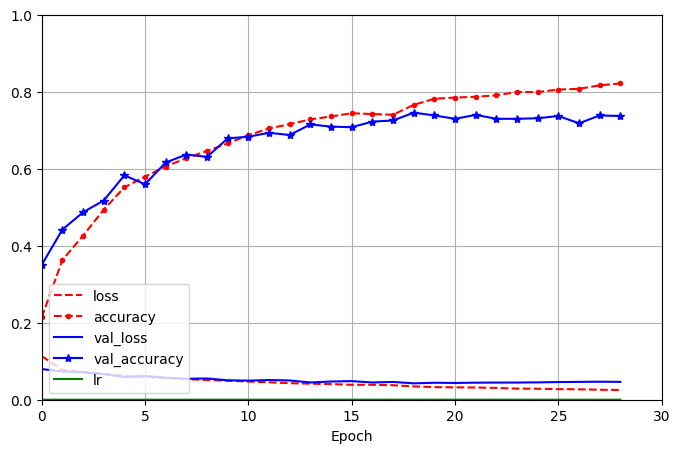

22/22 [==============================] - 16s 61ms/step
Overall Accuracy: 69.19%
              precision    recall  f1-score   support

         PVC       0.86      0.45      0.59        69
          AF       0.85      0.95      0.89       128
        LBBB       0.81      0.85      0.83        20
         STE       0.68      0.41      0.51        32
        IAVB       0.87      0.83      0.85        75
         PAC       0.67      0.04      0.07        55
           N       0.71      0.76      0.74        97
         STD       0.73      0.64      0.68        80
        RBBB       0.87      0.96      0.91       181

   micro avg       0.82      0.74      0.78       737
   macro avg       0.78      0.65      0.67       737
weighted avg       0.80      0.74      0.74       737
 samples avg       0.75      0.75      0.74       737

Accuracy (PVC): 93.75%
Accuracy (AF): 95.78%
Accuracy (LBBB): 98.98%
Accuracy (STE): 96.37%
Accuracy (IAVB): 96.80%

In [16]:
import tensorflow.keras as keras
import os
import tensorflow as tf
import datetime
import numpy as np
    
stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.00001)

# load the data from the file
samples = np.load(os.path.join("data", 'cpsc_2018_crtnet_multilabel_samples.npy'))
one_hot_encoding_labels = np.load(os.path.join("data", 'cpsc_2018_crtnet_multilabel_one_hot_encoding_labels.npy'))
classes = np.load(os.path.join("data", 'cpsc_2018_crtnet_multilabel_classes.npy'))

is_multilabel = any(sum(row) > 1 for row in one_hot_encoding_labels)

use_alternate = True # if True: leaky ReLU (alpha=0.3); dropout (rate=0.2); max pos encoding = 2048; SeLU activation on pre-output
initial_learning_rate = 0.0001

create_crtnet_method = create_crtnet_rwkv# create_crtnet_alternate if use_alternate else create_crtnet_original
model = create_crtnet_method(
    number_of_leads=samples.shape[2],
    num_classes=one_hot_encoding_labels.shape[1],
    multilabel=is_multilabel,
    learning_rate=initial_learning_rate)
# model already compiled. it can still be recompiled if needed

model.summary()

train_and_evaluate_model(
    model,
    samples=samples,
    one_hot_encoding_labels=one_hot_encoding_labels,
    callbacks=[reduce_lr, stopping],
    epochs=30,
    batch_size=64,
    classes=classes,
    multilabel=is_multilabel,
    style=["r--", "r--.", "b-", "b-*", "g-", "g-*"] # has f1 score so add green line for this
)



In [14]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import wfdb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# get stats of the data
samples = np.load(os.path.join("data", 'cpsc_2018_crtnet_singlelabel_samples.npy'))
one_hot_encoding_labels = np.load(os.path.join("data", 'cpsc_2018_crtnet_singlelabel_one_hot_encoding_labels.npy'))
classes = np.load(os.path.join("data", 'cpsc_2018_crtnet_singlelabel_classes.npy'))

print(f"Number of samples: {samples.shape[0]}")
print(f"Number of leads: {samples.shape[2]}")
print(f"Number of classes: {one_hot_encoding_labels.shape[1]}")
print(f"Classes: {classes}")

# get counts of each class
class_counts = np.sum(one_hot_encoding_labels, axis=0)
class_counts = dict(zip(classes, class_counts))
print(f"Class counts: {class_counts}")


Number of samples: 6877
Number of leads: 12
Number of classes: 19
Classes: ['PVC' 'AF' 'LBBB' 'STE' 'IAVB' 'PAC' 'N' 'STD' 'RBBB']
Class counts: {'PVC': 0.0, 'AF': 1081.0, 'LBBB': 342.0, 'STE': 605.0, 'IAVB': 96.0, 'PAC': 107.0, 'N': 655.0, 'STD': 362.0, 'RBBB': 295.0}
